<a href="https://colab.research.google.com/github/Jflorez05/Especializacion-Analitica/blob/main/%5BTALLER1a%5D_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


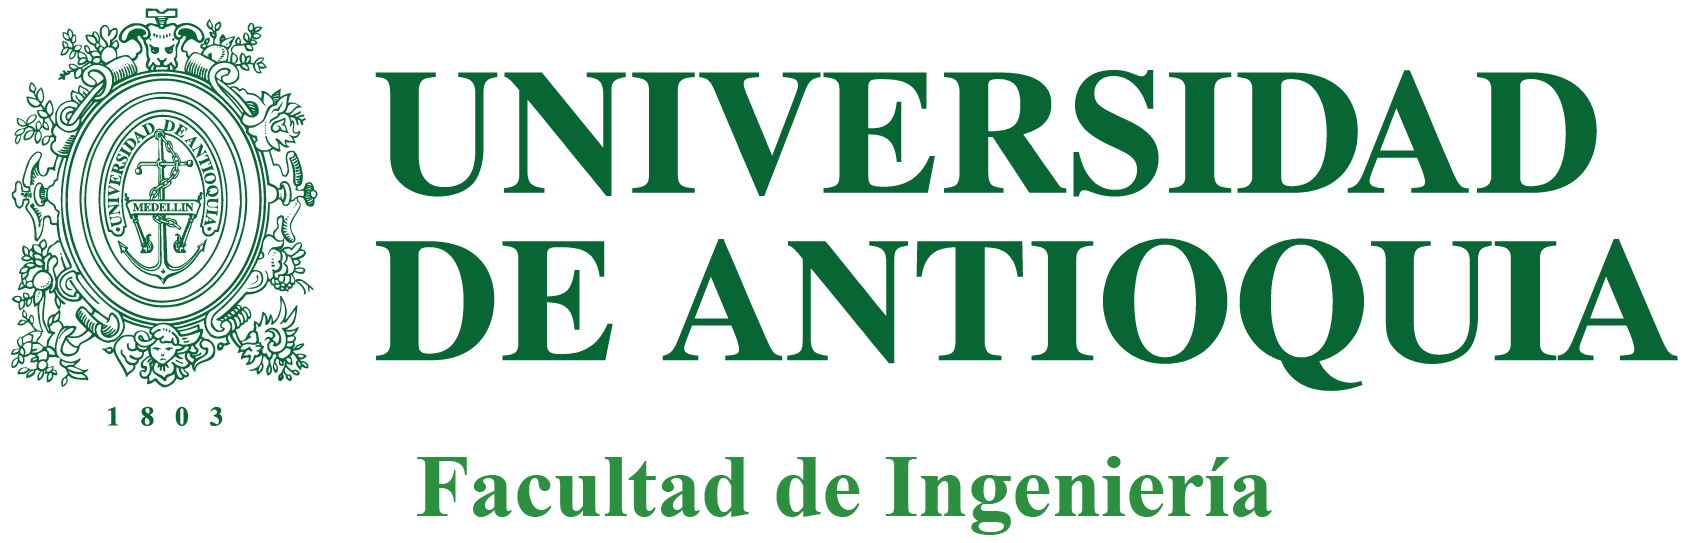
---
- **Asignatura:** Deep Learning
- **Profesor:** Hernán Felipe García Arias
- **Especialización en Analítica y Ciencia de Datos**
- **UdeA**
- **2024-2**

---

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

replicating local resources


In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

setting tensorflow version in colab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.17.0'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [4]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


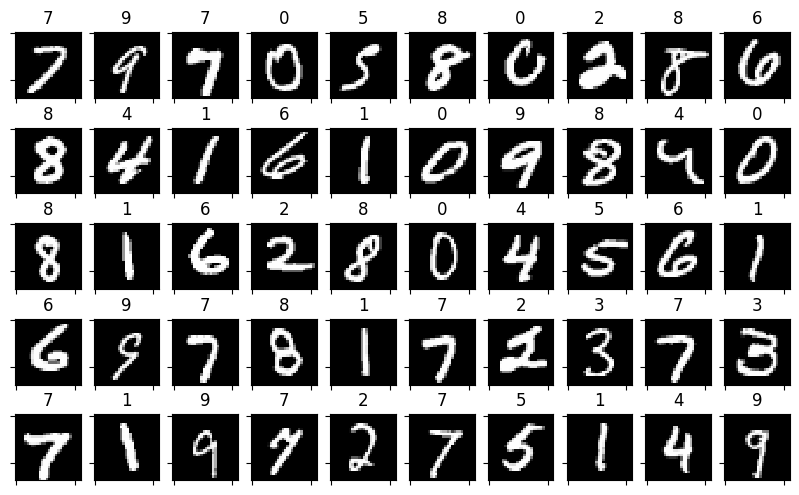

In [5]:
perm = np.random.permutation(list(range(X.shape[0])))[0:50]
random_imgs   = X[perm]
random_labels = y[perm]
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Autoencoder with small (sparse) activations

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [16]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l1
import tensorflow as tf

## Implement the following loss function

given:

- $k=50$, latent dimension
- $\mathbf{x}^{(i)} \in \mathbb{R}^{784}$
- $e(\mathbf{x}^{(i)}) \in \mathbb{R}^{k}$, the encoder
- $d(e(\mathbf{x}^{(i)})) \in \mathbb{R}^{784}$, the decoder

implement the following cost function

$$\text{loss}(\mathbf{x}^{(i)}) = \frac{1}{m}\sum_m \big(\mathbf{x}^{(i)} - d(e(\mathbf{x}^{(i)}))\big)^2 + \beta \frac{1}{k}\sum_{k,i} e(\mathbf{x}^{(i)})$$


In [44]:
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import tensorflow as tf

class CustomLossLayer(Layer):
    def __init__(self, beta=1.0, **kwargs):
        super(CustomLossLayer, self).__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        original, decoded, encoder_output = inputs
        # 1. Cálculo del error de reconstrucción (MSE)
        mse_loss = tf.reduce_mean(tf.square(original - decoded))
        # 2. Término de regularización sobre las activaciones del encoder
        regularization_loss = tf.reduce_mean(tf.abs(encoder_output))
        # 3. Función de pérdida total
        total_loss = mse_loss + self.beta * regularization_loss

        self.add_loss(total_loss)  # Agregar la pérdida al modelo

        return decoded  # Retorna la imagen decodificada sin modificación

def get_model(input_dim, code_size, beta=0.01):

    # Define the autoencoder layers
    inputs = Input(shape=(input_dim,), name="input")
    encoder = Dense(code_size, activation='relu', name="encoder")(inputs)
    outputs = Dense(input_dim, activation='sigmoid', name="output")(encoder)

    #avg_latent_activations = tf.reduce_mean(encoder, axis=1)
    custom_loss_layer = CustomLossLayer(beta=beta, name = "loss_with_regularizer")([inputs, outputs, encoder])
    model = Model(inputs, custom_loss_layer)
    model.compile(optimizer='adam')

    return model, encoder

In [45]:
# Parámetros del modelo
input_dim = 784  # Ejemplo: tamaño de imagen 28x28 aplanada
code_size = 50   # Dimensión de la capa latente

# Crear el modelo
model, encoder = get_model(input_dim, code_size)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Dense)           │ (None, 50)             │         39,250 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 784)            │         39,984 │ encoder[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ loss_with_regularizer     │ (None, 784)            │              0 │ input[0][0],           │
│ (CustomLossLayer)         │                        │                │ output[0][0],          │
│                           │                        │                │ encoder[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 79,234 (309.51 KB)

 Trainable params: 79,234 (309.51 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model, encoder = get_model(input_dim=X.shape[1], code_size=50, beta=0.001)

try with larger layer, try with more layers

In [50]:
model.fit(X_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1868
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0730
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0653
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0569
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0496
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0450
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0421
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0396
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0368
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0334
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0294
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0286
Epoc

In [ ]:
fl = K.function([model.input], [avg_latent_activations])
fl(X_train)

[array([4.4608349e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.8072491e-01, 3.8508105e-01, 4.1526198e-01,
        1.7899944e-03, 0.0000000e+00, 0.0000000e+00, 4.2354482e-01,
        0.0000000e+00, 0.0000000e+00, 3.9055079e-01, 0.0000000e+00,
        3.2591656e-01, 6.4026034e-01, 0.0000000e+00, 4.1022152e-01,
        5.5418462e-01, 6.2894529e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.8380924e-01,
        0.0000000e+00, 0.0000000e+00, 3.5680971e-01, 0.0000000e+00,
        0.0000000e+00, 5.9563463e-04, 0.0000000e+00, 4.6177214e-01,
        0.0000000e+00, 5.4042482e-01, 0.0000000e+00, 0.0000000e+00,
        5.9360516e-01, 0.0000000e+00, 4.7642380e-01, 0.0000000e+00,
        5.6514001e-01, 0.0000000e+00, 3.5979575e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00], dtype=float32)]

###  test the reconstruction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


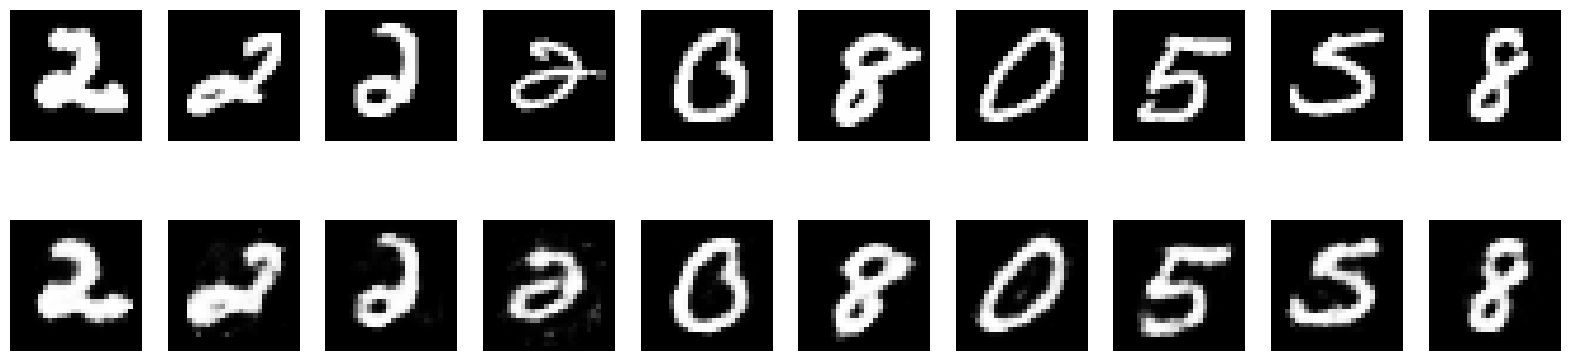

In [51]:
X_sample = np.random.permutation(X_test)[:10]
X_pred   = model.predict(X_sample)

plt.figure(figsize=(20,5))
for i in range(len(X_sample)):
    plt.subplot(2,len(X_sample),i+1)
    plt.imshow(X_sample[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample),len(X_sample)+i+1)
    plt.imshow(X_pred[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")

### show the weights

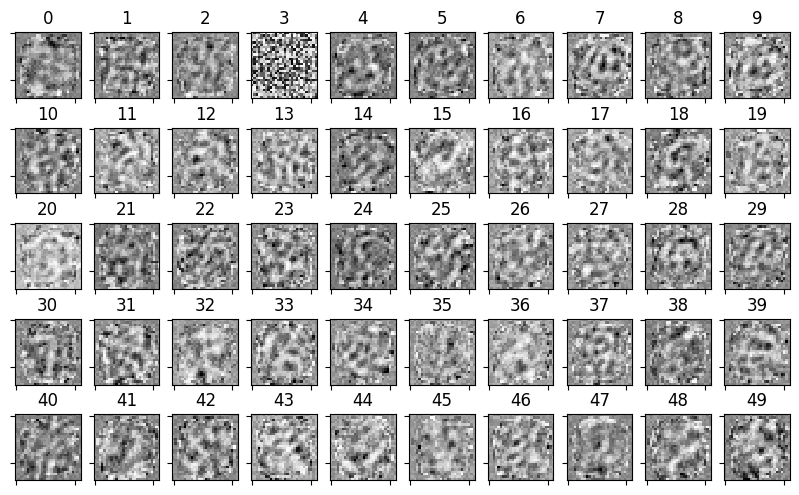

In [53]:
#Show the weights
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
# Assuming 'encoder' is a layer within a model,
# you can access its weights using model.layers
for i, layer in enumerate(model.layers): # Iterate through layers in the model
    if layer.name == "encoder":  # Replace with the actual name of your encoder layer
        encoder_layer = layer  # Store the actual encoder layer
        break  # Stop searching once found

for i in range(50):
    ax=fig.add_subplot(5,10,i+1)
    # Now use encoder_layer to get the weights
    plt.imshow(encoder_layer.get_weights()[0][:,i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(i)
    ax.set_xticklabels([])
    ax.set_yticklabels([])


### show activations in latent space

you should get something similar to this, indicating a much more sparse representation

In [54]:
# prompt: Del modelo que se viene construyendo puedes crear una grafica en la que se vean las activaciones en el espacio latente para las diferentes clases

# Obtain the latent space representations for the training data
latent_representations = encoder.predict(X_train)

# Create a scatter plot of the latent space representations, colored by class label
plt.figure(figsize=(10, 8))
for i in range(10):  # Assuming you have 10 classes (digits 0-9)
  indices = np.where(y_train == i)
  plt.scatter(latent_representations[indices, 0], latent_representations[indices, 1], label=str(i))

plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Representation of MNIST Digits")
plt.legend()
plt.show()

AttributeError: 'KerasTensor' object has no attribute 'predict'

https://github.com/rramosp/2021.deeplearning/blob/main/content/U2.05%20-%20Network%20Architectures%20-%20Autoencoders.ipynb

Seguir trabajando con el notebook de rramosp que ahí estan las gráficas

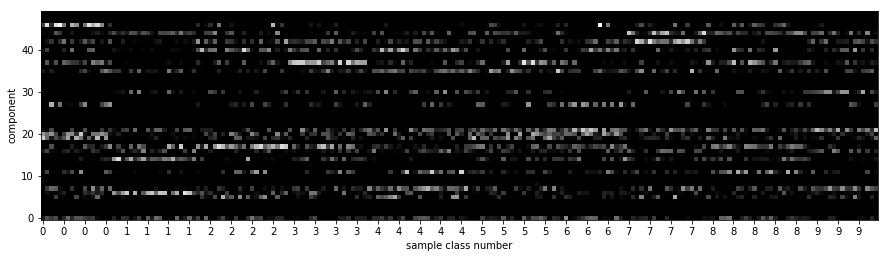

In [ ]:
from IPython.display import Image
Image(filename='local/imgs/ae_sparse_activations.png')

In [ ]:
...

### show the distribution of activations in latent space

should be quite concentrated at 0

In [ ]:
...

### show most representative neuron in latent space for each class

now, representative neurons must show somewhat distinctive shapes for each number


In [ ]:
...